In [1]:
import torch
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image

from homography import *

DEVICE="cuda"

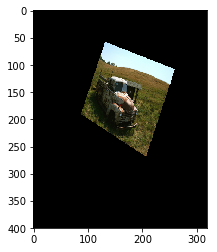

In [3]:
image = Image.open('./COCO_test2014_000000000182.jpg').resize((320,400),Image.ANTIALIAS)
image_array = np.array(image)[:,:,0]
transform, _ = sample_homography(torch.Tensor(image_array.shape))
invH = invert_homography(transform)
warped_image = image.transform(size=image.size, 
                               method=Image.PERSPECTIVE,
                               data=invH[0].numpy(),
                               resample=Image.BILINEAR)
warped_image_array = np.array(warped_image)[:,:,0]
plt.imshow(warped_image)

In [4]:
H, W = image_array.shape
net_image = image_array.reshape((1, 64, H//8, W//8)).repeat(5, axis=0)
net_warped_image = warped_image_array.reshape((1, 64, H//8,W//8)).repeat(5, axis=0)
invH = invH.repeat(5,1)

In [6]:
# N * D * H/8 * W/8
desc_raw = torch.Tensor(net_image).to(DEVICE)
warped_desc_raw = torch.Tensor(net_warped_image).to(DEVICE)

mp = 1
mn = 0.2
ld = 250

In [11]:
def descriptor_head(desc_raw):
    desc = F.interpolate(desc_raw, scale_factor=8, mode='bilinear', align_corners=False)
    desc = F.normalize(desc, p=2, dim=1)
    return desc_raw, desc

# should use the raw descriptor output from the network
def descriptor_loss(desc, warped_desc, homographies):
    batch_size = desc.shape[0]
    Hc, Wc = desc.shape[-2:]
    
    p_hw = torch.stack(torch.meshgrid((torch.arange(Hc), torch.arange(Wc))), dim=-1).float()
    p_hw = p_hw * 8 + 8 // 2
    warped_p_hw, bound, mask = warp_point(homographies, p_hw)
    p_hw = p_hw.view(1,Hc,Wc,1,1,2).float()
    warped_p_hw = warped_p_hw.view(batch_size,1,1,Hc,Wc,2).float()
    s = torch.le(torch.norm(p_hw-warped_p_hw,p=2,dim=-1), 8).float().to(DEVICE)

    desc = desc.view((batch_size,Hc,Wc,1,1,-1))
    warped_desc = warped_desc.view((batch_size,1,1,Hc,Wc,-1))
    dot_prod = torch.sum(desc*warped_desc, dim=-1)

    loss = ld * s * torch.clamp(mp - dot_prod, min=0.) + (1-s) * torch.clamp(dot_prod - mn, min=0.)
    
    mask_tensor = torch.Tensor(mask / 255).to(DEVICE)
    mask_split = mask_tensor.split(8, 2) # dim 2
    mask_stack = [st.reshape(mask_tensor.shape[0],Hc,1,8*8) for st in mask_split]
    mask_out = torch.cat(mask_stack,2)
    
    mask_out = torch.cumprod(mask_out, dim=3)[:,:,:,-1]
    mask_out = mask_out.reshape(batch_size, 1, 1, Hc, Wc)
    
    normalization = torch.sum(mask_out) * (Hc * Wc)
    loss = torch.sum(loss * mask_out) / normalization
    return loss

In [12]:
descriptor_loss(desc_raw, warped_desc_raw, invH)

tensor(253439.1406, device='cuda:0')